In [33]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
import numpy
from xgboost import XGBRegressor

# ACB

In [34]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('ACB Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df=data.reset_index()['Price']

In [35]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [36]:
#chia train test lúc vẽ sơ đồ
train_size1 = int(0.7 * len(df))
train_data1 = df[:train_size1]
test_data1 = df[train_size1:]

#x_test1 = np.array(test_data1.index).reshape(-1, 1)
#y_test1 = np.array(test_data1)

In [37]:
# 4. Chia train test cho train model
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [38]:
# 5. Hàm Create Dataset

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [39]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
#X_val, yval = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [40]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# XGBoost

In [41]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(
    base_score=0.5,
    booster='gbtree',    
    n_estimators=1000,
    objective='reg:linear',
    max_depth=3,
    learning_rate=0.01
)

# Specify early_stopping_rounds only in the fit method, not in the constructor
model_xgb.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=50,
    verbose=False
)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [42]:
# 10. Dự báo dữ liệu test
y_pred_xgb=model_xgb.predict(X_test)

y_pred_new_xgb = scaler.inverse_transform(y_pred_xgb.reshape(1, -1))
y_test_new_xgb = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

In [43]:
# Chuẩn hóa dữ liệu y_pred_xgb
y_pred_xgb=scaler.inverse_transform(y_pred_xgb.reshape(-1,1))

In [44]:
test_score_mae_xgb = mean_absolute_error(y_test_new_xgb, y_pred_new_xgb)
test_score_mae_xgb

539.11444

In [45]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse_xgb = np.sqrt(mean_squared_error(y_test_new_xgb, y_pred_new_xgb))
test_score_mape_xgb = mean_absolute_percentage_error(y_test_new_xgb, y_pred_new_xgb) * 100
test_score_mda_xgb = calculate_mda(y_test_new_xgb, y_pred_new_xgb)

print('RMSE trên tập test là:', test_score_rmse_xgb)
print('MAPE trên tập test là:', test_score_mape_xgb, '%')
print('MDA trên tập test là:', test_score_mda_xgb, '%')

RMSE trên tập test là: 730.3323
MAPE trên tập test là: 2.3600924760103226 %
MDA trên tập test là: 34.834123222748815 %


In [46]:
#Dự đoán 30 tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

xgb_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model_xgb.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        xgb_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model_xgb.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        xgb_output.extend(yhat.tolist())
        
        i = i+1

1 day output [0.6361338]
2 day output [0.64370763]
3 day output [0.6377591]
4 day output [0.62505907]
5 day output [0.6579]
6 day output [0.6808014]
7 day output [0.6621528]
8 day output [0.68574125]
9 day output [0.68910134]
10 day output [0.7054268]
11 day output [0.69234467]
12 day output [0.6934156]
13 day output [0.70059365]
14 day output [0.71598625]
15 day output [0.6971912]
16 day output [0.7033399]
17 day output [0.7173704]
18 day output [0.7149033]
19 day output [0.7087439]
20 day output [0.7281197]
21 day output [0.7205458]
22 day output [0.7281197]
23 day output [0.7281197]
24 day output [0.7281197]
25 day output [0.7281197]
26 day output [0.7281197]
27 day output [0.7281197]
28 day output [0.7281197]
29 day output [0.7281197]


In [47]:
# Chuẩn hóa dữ liệu xgb_output
xgb_output = scaler.inverse_transform(np.array(xgb_output).reshape(-1,1))

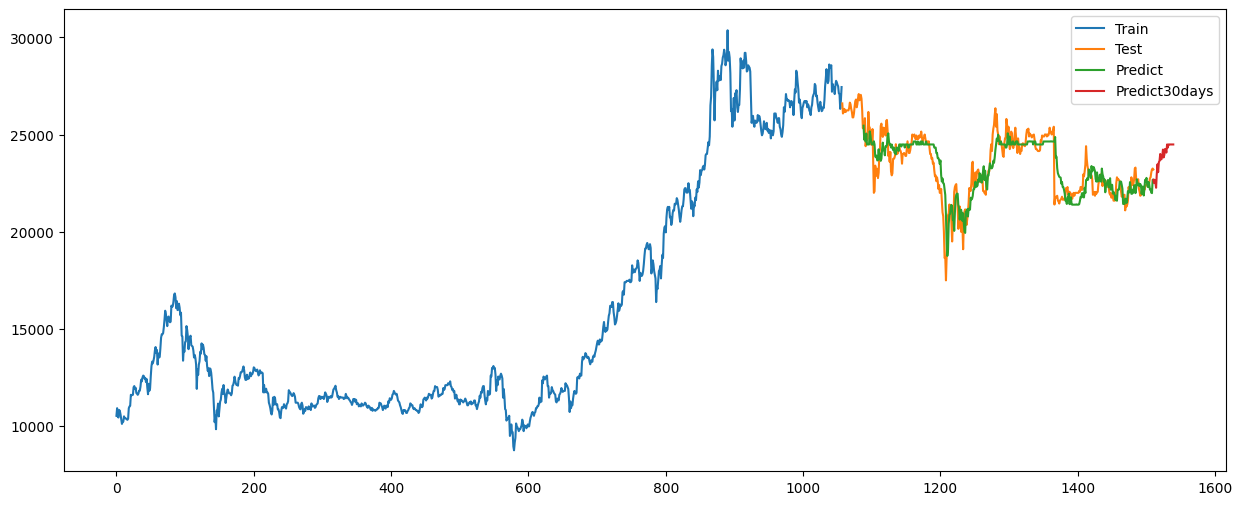

In [48]:
# 14.Vẽ hình
plt.figure(figsize=(15, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,train_data1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_data1)
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_xgb)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,xgb_output)
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()


# LSTM

In [49]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
#X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [50]:
# 8. Define LSTM Model

model_lstm=Sequential()
model_lstm.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model_lstm.add(LSTM(50,return_sequences=True))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [51]:
# 9. Fit mô hình với dữ liệu train
model_lstm.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 63ms/step - loss: 0.0381 - val_loss: 0.0105
Epoch 2/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 3/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 4/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 5/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0019 - val_loss: 0.0062
Epoch 6/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0018 - val_loss: 0.0075
Epoch 7/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 8/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 9/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 10/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0017 - val_loss: 0.0028

In [52]:
# 10. Dự báo dữ liệu test, val
y_pred_lstm=model_lstm.predict(X_test)
#y_pred_val=model.predict(X_val)

y_pred_new_lstm = scaler.inverse_transform(y_pred_lstm.reshape(1, -1))
y_test_new_lstm = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

14/14 [==============================] - 1s 6ms/step


In [53]:
# Chuẩn hóa dữ liệu y_pred_lstm
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

In [54]:


# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse_lstm = np.sqrt(mean_squared_error(y_test_new_lstm, y_pred_new_lstm))
test_score_mape_lstm = mean_absolute_percentage_error(y_test_new_lstm, y_pred_new_lstm) * 100
test_score_mda_lstm = calculate_mda(y_test_new_lstm, y_pred_new_lstm)

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm, '%')
print('MDA trên tập test là:', test_score_mda_lstm, '%')

RMSE trên tập test là: 597.7169
MAPE trên tập test là: 1.814032532274723 %
MDA trên tập test là: 42.89099526066351 %


In [55]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model_lstm.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_lstm.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.66532713]
395
1 day input [0.76570712 0.76570712 0.74950109 0.78422829 0.78654344 0.76107682
 0.700883   0.71014359 0.68699211 0.71014359 0.66384064 0.65458006
 0.65921035 0.69393756 0.69393756 0.6962527  0.70319814 0.72866476
 0.71477388 0.70551329 0.70782844 0.71708903 0.72634961 0.71477388
 0.71245873 0.70551329 0.68236182 0.70551329 0.70551329 0.70782844
 0.70551329 0.700883   0.700883   0.71940417 0.7356102  0.72171932
 0.70782844 0.70782844 0.71477388 0.72634961 0.73329506 0.75181623
 0.74718594 0.74950109 0.75181623 0.74487079 0.7402405  0.74950109
 0.74487079 0.7402405  0.74255564 0.74950109 0.74487079 0.74950109
 0.75876167 0.74487079 0.7356102  0.74255564 0.74487079 0.75181623
 0.74255564 0.73097991 0.73097991 0.7356102  0.72866476 0.7356102
 0.71940417 0.70551329 0.70551329 0.69393756 0.6962527  0.68236182
 0.68467697 0.66615579 0.65226491 0.65458006 0.64068917 0.64994976
 0.64068917 0.622168   0.63142858 0.61290741 0.61290741 0.622168
 0.59438623 0.56660447 0.55734388 0.

In [56]:
# Chuẩn hóa dữ liệu lst_output
lst_output = scaler.inverse_transform(lst_output)

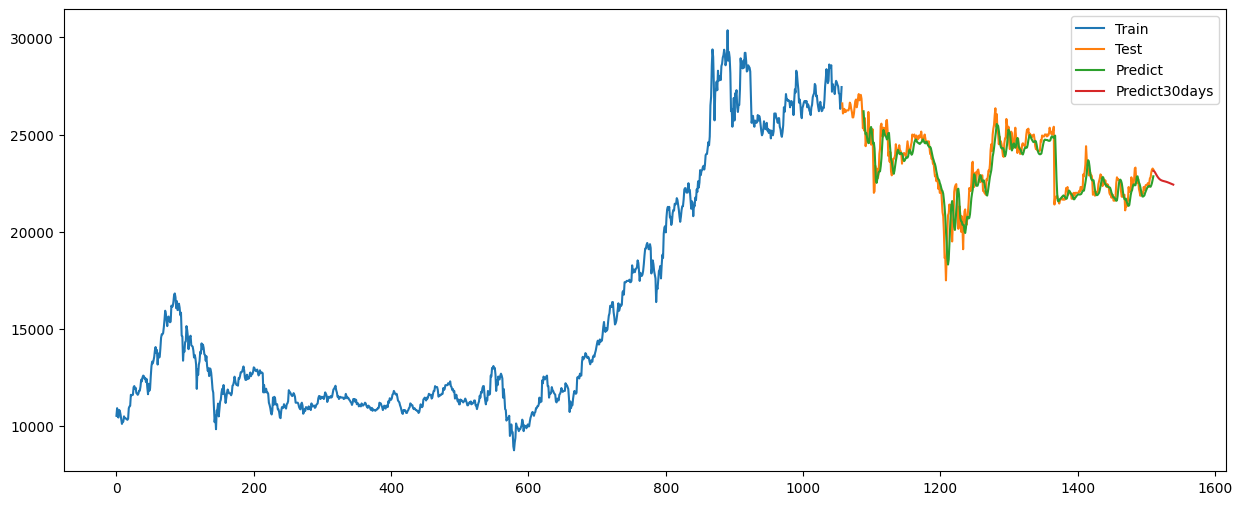

In [57]:
plt.figure(figsize=(15, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,train_data1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_data1)
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_lstm)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index, lst_output)
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

# COMBINATION XGBoost-LSTM

In [58]:
combined_predictions = (y_pred_lstm + y_pred_xgb) / 2
combined_predictions_new = scaler.inverse_transform(y_pred_lstm.reshape(1, -1))
y_test_actual = scaler.inverse_transform(np.array([y_test], dtype=np.float32))
y_test_actual_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [59]:
# Evaluate combined model
mse_combined = mean_squared_error(y_test_actual, combined_predictions_new)
print(f'Mean Squared Error (Combined Model): {mse_combined}')

Mean Squared Error (Combined Model): 2.495925754789888e+17


In [60]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse_combined = np.sqrt(mean_squared_error(y_test_actual, combined_predictions_new))
test_score_mape_combined = mean_absolute_percentage_error(y_test_actual, combined_predictions_new) * 100
test_score_mda_combined = calculate_mda(y_test_actual, combined_predictions_new)

print('RMSE trên tập test là:', test_score_rmse_combined)
print('MAPE trên tập test là:', test_score_mape_combined, '%')
print('MDA trên tập test là:', test_score_mda_combined, '%')

RMSE trên tập test là: 499592420.0
MAPE trên tập test là: 2148410.9375 %
MDA trên tập test là: 42.89099526066351 %


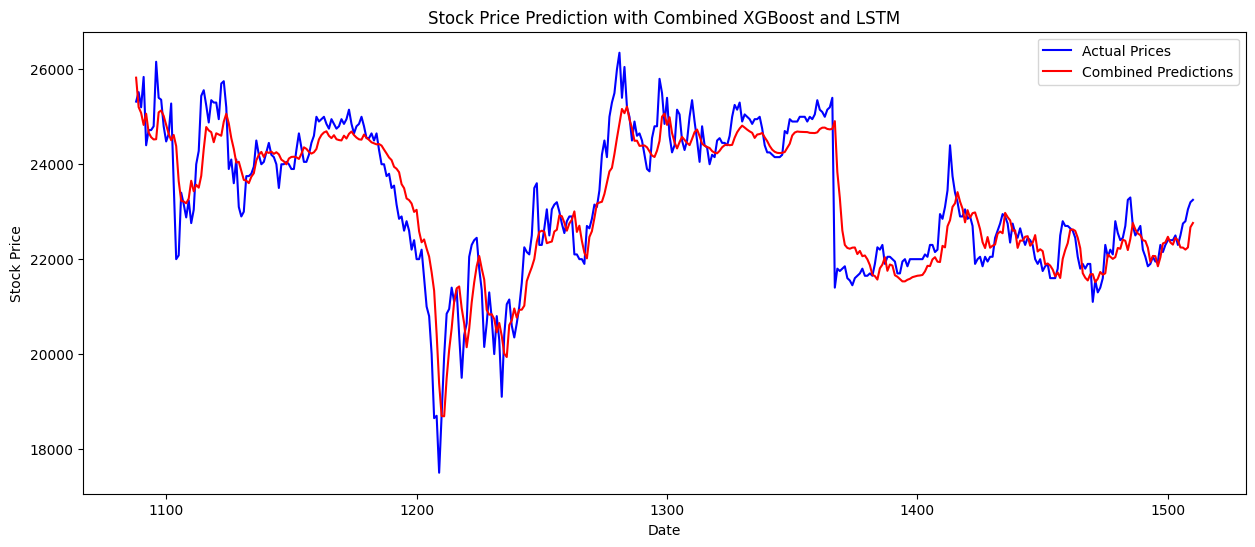

In [61]:
# Visualize predictions
plt.figure(figsize=(15, 6))
plt.plot(data.index[-len(y_test_actual_new):], y_test_actual_new, label='Actual Prices', color='blue')
plt.plot(data.index[-len(combined_predictions):], combined_predictions, label='Combined Predictions', color='red')
plt.title('Stock Price Prediction with Combined XGBoost and LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [62]:
combined_predict_30_day = (lst_output + xgb_output)/2

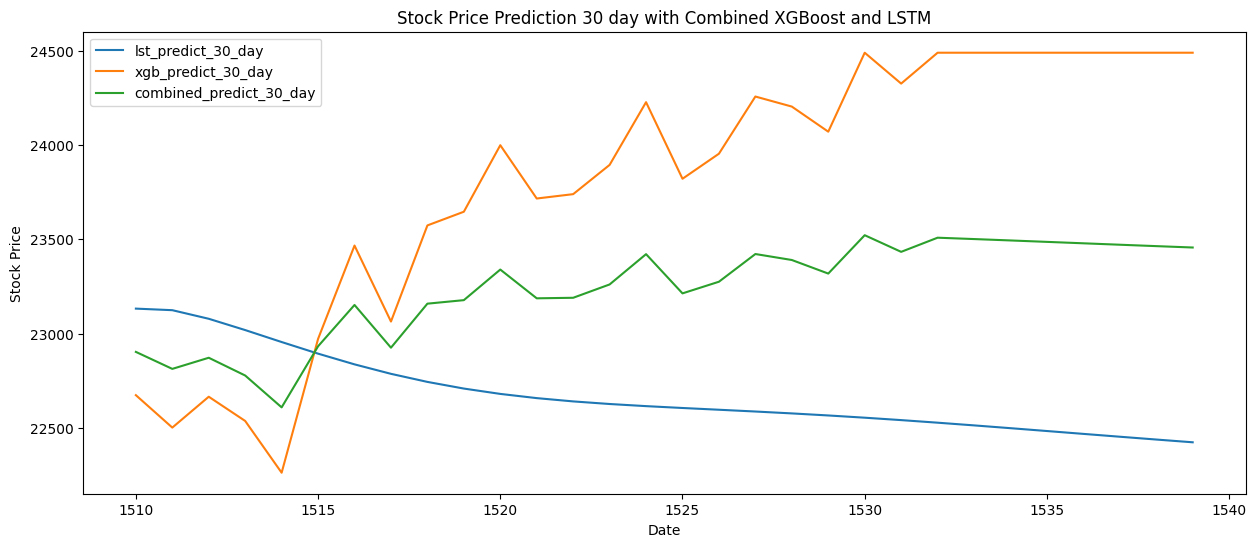

In [63]:
# Visualize predictions
plt.figure(figsize=(15, 6))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index, lst_output, label = 'lst_predict_30_day')
plt.plot(prediect_data_index, xgb_output, label = 'xgb_predict_30_day')
plt.plot(prediect_data_index, combined_predict_30_day, label = 'combined_predict_30_day')
plt.title('Stock Price Prediction 30 day with Combined XGBoost and LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

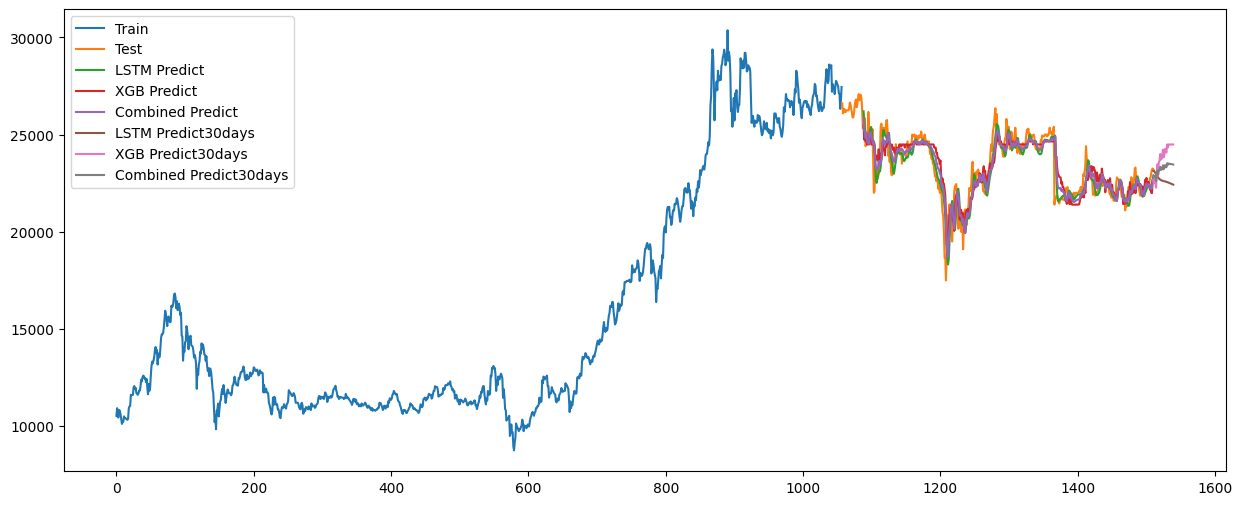

In [64]:
plt.figure(figsize=(15, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,train_data1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_data1)
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_lstm)
plt.plot(test_data_index,y_pred_xgb)
plt.plot(test_data_index,combined_predictions)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index, lst_output)
plt.plot(prediect_data_index, xgb_output)
plt.plot(prediect_data_index, combined_predict_30_day)
plt.legend(['Train','Test','LSTM Predict','XGB Predict','Combined Predict','LSTM Predict30days','XGB Predict30days','Combined Predict30days'])
plt.show()